<div style="background-image: url('https://images.unsplash.com/photo-1536164584269-9381144ba8f0?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=634&q=80'); background-size: 40%; background-repeat: no-repeat; background-position: right;">

# Shifted Ackley’s Function

$F_6(x) = -20exp(-0.2 \sqrt {\frac {1}{D} \sum_{i=1}^Dz_i^2}) - exp(\frac {1}{D} \sum_{i=1}^Dcos(2 \pi z_i)) + 20 + e + f_{bias_6}$, 
    
    
$ z = x - o $, $x = [x_1,x_2,...,x_D]$

D: dimensions. $o = [o_1, o_2, ..., o_D]$ : the shifted global optimum.

### Properties:
- Multi-modal
- Shifted
- Separable
- Scalable
- Dimension D as 100, 500 and 1000
- $x∈[−32,32]^D$ , Global optimum $x^* = o$ , $F_6(x^*) = f_{bias_6} = -140$
    
</div>

In [2]:
import sys
sys.path.append('../') # just to allow using python files at another directory

import numpy as np
from shifted_go import * # shifted global optimum of the functions
from algorithms import * # optimization algorithms customized
from utils import * # functions used to summarise the results

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pygmo as pg # package with the optimization algorithms
import time
import pandas as pd

## I. Defining the class for the optimization algorithm
<hr>

In [3]:
class shifted_ackley:
    
    def __init__(self, dim):
        self.dim = dim
        self.name = 'shifted Ackley'

    def fitness(self, x):
        
        z = np.array(x)
        if z.ndim <= 1:
            if np.isscalar(x) == True:
                z = z - ackley[0]
                factor = 1
                res = -20*np.exp(-.2*np.sqrt(factor*np.sum(z**2))) - np.exp(factor*np.sum(np.cos(2*np.pi*z)))
            else:
                z = z - ackley[:len(z)]
                factor = 1/len(z)
                res = -20*np.exp(-.2*np.sqrt(factor*np.sum(z**2))) - np.exp(factor*np.sum(np.cos(2*np.pi*z)))
        else:
            z = z - ackley[:z.shape[1]]
            factor = 1/z.shape[1]
            res = -20*np.exp(-.2*np.sqrt(factor*np.sum(z**2, axis=1))) - np.exp(factor*np.sum(np.cos(2*np.pi*z), axis=1))

        return [res + 20 + np.e + f_bias[5]]

    def get_bounds(self):
        return ([-32]*self.dim,[32]*self.dim)
    
    def get_nic(self): # number of inequality constraints
        return 0
    
    def get_nec(self): # number of equality constraints
        return 0
    
    def get_name(self): # number of equality constraints
        return self.name + ' - dimension ' + str(self.dim)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

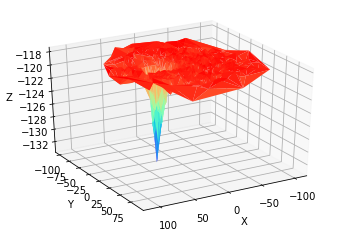

In [4]:
grid = 32*np.random.randn(1000, 2)
function = shifted_ackley(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.view_init(30, 60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# II. Optimizing the function using metaheuristics

<hr>

## II.1 Dimension = 50 

As the function shifted sphere is multimodal and separable we are going to choose PSO to explore a great range making the convergence of the swarm fast to the optimal solution.

### Parameters selection

Once we have an multimodal function we are going to set a high social component to privilege particles that find the best solution, whereas the cognitive component will be small. We are going to set a small number to the maximum allowed particle velocity to increase intensification. The inertia will be set to reduce a little bit the current velocity to privilege the other components of velocity.

We have analyzed empirically that the following parameters bring the best results to particle swarm using the package PyGMO:

- <b>variant - 6 </b> Fully Informed (FIPS)
- <b>neighb_type – 2 </b> Ibest swarm topology
- <b>neighb_param – 4 </b> neighbours 

<font color ='blue'>a) Inertia:</font> 0.7

In [31]:
udas = [pg.pso_gen(gen=200, omega= .9, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .5, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_ackley(50), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.9, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1695774004, Verbosity: 1]",0.183089,5025,-121.687870,-122.710945,-122.231622,-122.260912
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2456926504, Verbosity: 1]",0.177487,5025,-134.918812,-136.208119,-135.670735,-135.691357
2,"[Generations: 200, Omega: 0.5, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3391241732, Verbosity: 1]",0.182383,5025,-119.398497,-120.500470,-119.947779,-119.885726


<font color ='blue'>b) Maximum allowed particle velocities: </font> 0.25

In [32]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = 1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_ackley(50), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1895463408, Verbosity: 1]",0.179100,5025,-119.404627,-135.619857,-121.077081,-119.758577
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 4227625062, Verbosity: 1]",0.179754,5025,-134.892484,-136.820860,-136.098157,-136.210112
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1467627502, Verbosity: 1]",0.184065,5025,-134.658317,-136.204116,-135.544171,-135.480873
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 335015094, Verbosity: 1]",0.181831,5025,-134.716482,-136.441737,-135.675727,-135.760043


<font color ='blue'>c) Number of neighbours to consider: </font> 4

In [35]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 2, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 3, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False)]

df = statistics(shifted_ackley(50), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 2, Memory: false, Seed: 2772562246, Verbosity: 1]",0.171898,5025,-127.973922,-129.929653,-128.748665,-128.651071
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 3, Memory: false, Seed: 1707043685, Verbosity: 1]",0.174507,5025,-127.501499,-129.392090,-128.522657,-128.545202
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2157094776, Verbosity: 1]",0.175787,5025,-135.194756,-136.707191,-136.065719,-136.035582
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 47653013, Verbosity: 1]",0.177152,5025,-134.842279,-136.845663,-135.863763,-135.877141


<font color ='blue'>d) Social and cognitive influence: </font> 

We see that it's possible to ha good results using two configurations:
- high social and low cognitive component;
- low social and high cognitive component.

In [43]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=1, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=2, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=3, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=4, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=.5, eta2=4, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=1, eta2=4, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=2, eta2=4, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=3, eta2=4, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_ackley(50), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1914358885, Verbosity: 1]",0.178878,5025,-135.343020,-136.590648,-136.001378,-136.027917
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1976926936, Verbosity: 1]",0.177500,5025,-133.870056,-135.435469,-134.774825,-134.862668
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 2, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 565760630, Verbosity: 1]",0.179419,5025,-129.710675,-131.228820,-130.447341,-130.474052
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 3, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 21773241, Verbosity: 1]",0.187326,5025,-126.907320,-127.913537,-127.522169,-127.573825
4,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 4, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2218185301, Verbosity: 1]",0.175457,5025,-125.735508,-127.184598,-126.392639,-126.399561
5,"[Generations: 200, Omega: 0.7, Eta1: 0.5, Eta2: 4, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3992893134, Verbosity: 1]",0.177088,5025,-135.392159,-136.628477,-136.062181,-136.085398
6,"[Generations: 200, Omega: 0.7, Eta1: 1, Eta2: 4, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3329093001, Verbosity: 1]",0.175087,5025,-134.072517,-135.054746,-134.619878,-134.649991
7,"[Generations: 200, Omega: 0.7, Eta1: 2, Eta2: 4, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 719356985, Verbosity: 1]",0.181541,5025,-129.715015,-131.110254,-130.358427,-130.346800
8,"[Generations: 200, Omega: 0.7, Eta1: 3, Eta2: 4, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3639330921, Verbosity: 1]",0.175898,5025,-127.289172,-128.579148,-127.576287,-127.487120


<font color ='blue'>e) Number of Generations </font>: 500

In [41]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 2, memory=False), 
        pg.pso_gen(gen=300, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 3, memory=False),
       pg.pso_gen(gen=400, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=500, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False),
       pg.pso_gen(gen=600, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False)]

df = statistics(shifted_ackley(50), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 2, Memory: false, Seed: 1075931111, Verbosity: 1]",0.171055,5025,-126.480173,-129.647556,-128.302577,-128.490603
1,"[Generations: 300, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 3, Memory: false, Seed: 2233079794, Verbosity: 1]",0.257208,7525,-129.951127,-131.580374,-130.829831,-130.830929
2,"[Generations: 400, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3172068303, Verbosity: 1]",0.346131,10025,-139.214834,-139.906161,-139.731605,-139.798836
3,"[Generations: 500, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 2762014474, Verbosity: 1]",0.462044,12525,-139.867440,-139.975814,-139.951898,-139.957847
4,"[Generations: 600, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 821892554, Verbosity: 1]",0.536820,15025,-139.949273,-139.995467,-139.987872,-139.991967


After analyzing the statistics of the different parameters we decide for the following configuration:

- gen = 400
- omega = .7
- eta1 = 4
- eta2 = 0.5
- max_vel = .25
- variant = 6
- neighb_type = 2
- neighb_param = 4
- memory = False
- pop_size = 25

Number of function evaluations:  344375.0
Final solution vector:  [ 27.00782937 -16.13227116   6.41059938  -0.83850525  23.47774987
  15.72341097  -2.61120805 -28.89138064  19.28411564  -3.31728856
   6.92447462  17.51634939  25.30959266  14.2921403  -19.42221437
  -5.65741341  26.12965119  25.01431336  -5.38268853  23.61852278
 -26.52628089  -8.82743678  18.79055878 -29.40797879 -21.66660952
 -17.8350659  -18.07614585   6.22761926 -13.66935294 -18.07229938
 -29.08588911  14.8057605   -3.29486881  25.90927624  -2.04173102
  -4.88184378  20.77119547   1.50733666 -17.840401    10.32622336
  20.28931814 -28.82211089  10.87854127  -7.23045464  19.90830849
   0.16732677  12.56737089  -4.26750944 -11.72478211 -18.62060369]
Fitness:  [-139.99521407]
Wall time: 12.2 s


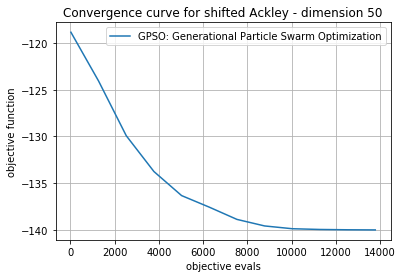

In [45]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = pso(shifted_ackley(50), gen=400, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False, pop_size=25)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

<hr>

## II.2 Dimension = 500


### Parameters selection

Given the characteristics of Ackley's function we are going to set a high start temperature to reduce the probability of getting stuck at a local minima. Since it's a trajectory algorithm, there is no influence at all the increase of the population size. 

The final temperature will be set to a small number in such a way that we reduce the probability to accept solutions that do not improve the fitness. The parameters that define the number of temperature and range adjustments, as well the number of mutations that are used to compute the acceptance rate are going to be defined empirically.

<font color ='blue'>a) Initial Temperature:</font> 1

In [60]:
udas = [pg.simulated_annealing(Ts=100, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1), 
        pg.simulated_annealing(Ts=10, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1)]

df = statistics(shifted_ackley(500), udas, epochs = 1)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Starting temperature: 100, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1390910176, Verbosity: 1]",0.158429,62501,-138.796466,-138.796466,-138.796466,-138.796466
1,"[Starting temperature: 10, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1791157007, Verbosity: 1]",0.158143,62501,-138.797588,-138.797588,-138.797588,-138.797588
2,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 3015999992, Verbosity: 1]",0.157513,62501,-139.801651,-139.801651,-139.801651,-139.801651


<font color ='blue'>b) Number of temperature adjustments:</font> 15

In [61]:
udas = [pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=5, n_range_adj=5, bin_size=5, start_range=1), 
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=10, n_range_adj=5, bin_size=5, start_range=1),
        pg.simulated_annealing(Ts=1, Tf=1e-12, n_T_adj=15, n_range_adj=5, bin_size=5, start_range=1)]

df = statistics(shifted_ackley(500), udas, epochs = 1)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 5, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1767736729, Verbosity: 1]",0.156811,62501,-139.872325,-139.872325,-139.872325,-139.872325
1,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 10, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1376182917, Verbosity: 1]",0.314854,125001,-139.137399,-139.137399,-139.137399,-139.137399
2,"[Starting temperature: 1, Final temperature: 1e-12, Number of temperature adjustments: 15, Number of range adjustments: 5, Bin size: 5, Starting range: 1, Seed: 1887555301, Verbosity: 1]",0.475468,187501,-140.000000,-140.000000,-140.000000,-140.000000


Number of function evaluations:  4687500.0
Final solution vector:  [ 27.00775711 -16.13168919   6.41055501  -0.84105188  23.47793797
  15.72580998  -2.61194009 -28.88978141  19.28442986  -3.31779814
   6.92594089  17.51622225  25.30877824  14.29243475 -19.42403133
  -5.65762722  26.12818195  25.01426639  -5.38378758  23.61897185
 -26.52652171  -8.82791207  18.78998984 -29.40832196 -21.66654708
 -17.83408689 -18.07669544   6.22754875 -13.6687245  -18.07114393
 -29.08356438  14.80714059  -3.29421406  25.90887471  -2.0403395
  -4.88103194  20.77328507   1.50914978 -17.84115854  10.32824811
  20.2871067  -28.82162917  10.87662968  -7.23113892  19.90776106
   0.16877304  12.56828356  -4.26645808 -11.72295799 -18.62077515
 -18.39413062  10.93339342 -11.83413595   2.50043124 -20.94762143
  11.87390891  -7.29761997  21.60069629  21.21930784   5.61377475
  -0.20685302  23.98615051  19.29774964   8.69462305  19.07846045
   9.61365339  -9.4817629  -12.61644625  -9.52838583   2.04474106
  13.62679

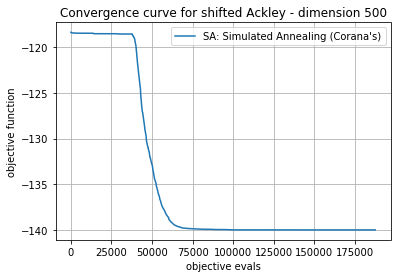

In [62]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = sa(shifted_ackley(500), Ts=1, Tf=1e-12, n_T_adj=15, n_range_adj=5, bin_size=5, start_range=1, pop_size=1)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)